# 3D Geometric Model of Inflated Dunnage Bag - Reduction in Void

## Assumptions:

1. Material is rigid
2. Idealized geometry
3. Rate dependent

## Import Libraries:

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt, numpy as np
from scipy.interpolate import spline
from math import pi #import pi function for simple reference

## Functions:

In [2]:
#Find volume from length, width and diameter
def updateGeometricVolume(width,length,diameter):
    LengthLong = width - float(pi*diameter)/2 
    AreaLong = diameter*LengthLong + float(pi*diameter**2)/4
    LengthShort = length - float(pi*diameter)/2
    AreaShort = diameter*LengthShort + float(pi*diameter**2)/4
    VolumeSphere = float(1/6)*(diameter**3)*(pi)
    return (AreaLong*LengthShort) + (AreaShort*LengthLong) + VolumeSphere

In [3]:
#Update the Pressure using Ideal Gas Law
def updatePressure(temperature,mass,volume):
    return ((mass/M_air)*8.3144598*(temperature + 273.15))/volume

In [4]:
#Update the Volume using Ideal Gas Law
def updateVolume(temperature,mass,pressure):
    return ((mass/M_air)*8.3144598*(temperature + 273.15))/(101500-pressure)

In [5]:
#Get the mass using the Ideal Gas Law (ABSOLUTE PRESSURE)
def updateMass(temperature,pressure,volume):
    #return((101500+pressure)*volume)/(8.3144598*(temperature + 273.15))
    return(M_air*(pressure)*volume)/(8.3144598*(temperature + 273.15))
    #return((pressure)*volume)/(8.3144598*(temperature + 273.15))

In [6]:
#Find the new length using the strain calculated
def updateLength(length,strain):
    ChangeInLength = length*strain 
    return length+ChangeInLength

In [7]:
#Get the mass loss rate (J -> flux) from Fick's Law
#def getMassLossRate(Permeability,dp,t):
    #return Permeability*(dp/t) #assume no change in t?

In [8]:
#get density of air based on temperature
def getRho(P,T):
    R_specific=287.058 #R_air / M_air
    return (P+101325) / (R_specific * (T + 273.15)) 

In [9]:
def getMassLossRate(rho,Vnew,time):
    return rho*Vnew/time

In [10]:
def updateMassPermeability(m1,m_dot,dt):
    return m1 + m_dot*dt

In [11]:
def getVolumePermeability(Permeability,area,time,dp,thickness):
    return Permeability*area*time*dp/thickness

## Input Parameters - Main A:

In [12]:
#Constants:
w=0.9
d=0.5
l=[1.5] #initial length

#Initial values:
T = [30,40,50,60] #permeability temperature values
M_air = 0.02897 #gas constant of air (g/mol)

P=[20000]  # [Pa] initial GAUGE pressure (20 kPa)
V=[1] #[m^3]
m=[updateMass(T[0],P[0],V[0])] #initial mass from Ideal Gas Law

#print ('sig =',sig,'\n','eps =',eps,)
print ('\n','P =',P,'\n','V =',V,'\n','m =',m)

# Main A - loop parameters:
max_iter = 20 #maximum number of iterations
m_tol = 0.0005 #mass tolerance
i = 0 #starting number of iteration
m_diff = 10.0 #
m_old = 100 #old mass 


 P = [20000] 
 V = [1] 
 m = [0.22987242662537494]


## Main A - Just Inflated:

In [13]:
print("{0}      {1}          {2}          ".format("P","V","m"))
while (m_diff >= m_tol and i < max_iter):
    P.append(P[0]) #update Pressure
    
    V.append(updateGeometricVolume(w,l[0],d)) #get Volume
    
    m.append(updateMass(T[0],P[0],V[i+1])) #initial mass from Ideal Gas Law, ABSOLUTE PRESSURE
    
    #Loop constraints
    m_diff = np.abs(m[i+1] - m_old) #calculate abs difference between old m and new m
    m_old = m[i+1] #set the old m equal to the current m for the next loop
    
    print("{0}  {1:.6f}   {2:.6f}".format(P[i],V[i],m[i]))

    i+=1 #increment i to loop ,V,m,sig_b

P      V          m          
20000  1.000000   0.229872
20000  0.310158   0.071297


## Import Permeability Data:

In [14]:
def PermeabilityData():
    textfile = 'C:\\Users\\Inance\\Documents\\Thesis\\Experiments\\Permeability_Tests\\Permeability\\PE30_TESTER.txt'
    with open(textfile,'r') as file:
        lst = [] 
        for line in file:
            lst.append([ float(x) for x in line.split()])
        dt = np.array([ x[0] for x in lst])
        dp =np.array([ x[1] for x in lst])
        dp = (dp - dp[0])*-1000 #start change in pressure at 0.
    return dt,dp

In [15]:
Permeability_Time = []
Permeability_Pressure = []
Permeability_Time,Permeability_Pressure = PermeabilityData()
Time_perm_max = int(Permeability_Time[-1]-Permeability_Time[0])
Permeability_Time = range(Time_perm_max+1)
#print(len(Permeability_Time),len(Permeability_Pressure))
print(Permeability_Pressure)

[  -0.  -10.   -0. ..., -410. -410. -400.]


## Input Parameters - Main B:

In [16]:
# Main A - loop parameters:
max_iter = 100 #maximum number of iterations
m_tol = 0.0005 #mass tolerance
j = 0 #starting number of iteration
m_diff = 10.0 #
m_old = 100 #old mass 
list_size=1

#Input parameters for Main B:
Permeability = [1.88, 3, 6, 8] #measured values

m_dot=np.empty((list_size, 0)).tolist() #flux = mass loss rate
m_dot[0] = 0

P_perm=np.empty((list_size, 0)).tolist()
P_perm[0] = P[0] #diameter which is reduced
P_perm.append(P[0])
#P_perm[1] = P[0] #diameter which is reduced

rho=np.empty((list_size, 0)).tolist()
rho[0] = 1.5 #diameter which is reduced

m_ideal = [m[1]] #end mass of Main A, starting mass for Main B
m_perm = [m[1]] #end mass of Main A, starting mass for Main B

V_new = [V[1]] #end volume of Main A, starting volume for Main B
V_ideal = [V[1]]

l_perm = [l[0]] #end length of Main A, starting length for Main B

print("{0}    {1}   {2}    {3}  {4}   {5}   {6}".format("m_dot","P_perm","Perm","m_ideal","m_perm","V_new","V_ideal"))
print("{0:.4f}   {1}    {2:.4f}  {3:.4f}   {4:.4f}   {5:.4f}   {6:.4f}".format(m_dot[0],P_perm[0],Permeability[0],m_ideal[0],m_perm[0],V_new[0],V_ideal[0]))

m_dot    P_perm   Perm    m_ideal  m_perm   V_new   V_ideal
0.0000   20000    1.8800  0.0713   0.0713   0.3102   0.3102


## MAIN - Time loop:

In [17]:
#t_max_index = getIndex(Cyclic_Void,1) #time start
#t_min_index = getIndex(Cyclic_Void,2) #time end
#t_length = (Cyclic_Time.tolist()[t_min_index] - Cyclic_Time.tolist()[t_max_index]) #nr of data points in interested timeline
#t_length = int((Cyclic_Time.tolist()[t_min_index] - Cyclic_Time.tolist()[t_max_index])/0.02) #nr of data points in interested timeline
#time_relevant = [x * 0.02 for x in range(t_length)] #generate relevant time list
t_length = 7.22
print(t_length,t_length/0.02)
t=0

7.22 361.0


In [18]:
dp = Permeability_Pressure
thickness = 0.50 #thickness of PE film
A = l[0]*w

In [19]:
from scipy.ndimage import gaussian_filter1d
dp_smooth = gaussian_filter1d(dp, 1)
dp = dp_smooth.tolist()
inds=dp.index(dp[-1])
indms=dp.index(max(dp))
print(inds,indms)

2590 70


## Main B - Reduction in Void:

In [20]:
print("{0}      {1}    {2}      {3}   {4}   {5}  {6}".format("t","m_ideal","m_dot","m_perm","V_new","P_perm","rho"))

while t <= t_length and j < max_iter:
    
    m_ideal.append(updateMass(T[0],P_perm[j],V_new[j])) #calculate m1 from ideal gas law
    
    #m_dot.append(getMassLossRate(Permeability[0],dp[j],thickness))#caluculate FLUX (mass loss rate) from Ficks Law
    
    #m_dot.append(getMassLossRate(Permeability[0],dp[j],thickness))#caluculate FLUX (mass loss rate) from Ficks Law
    
    V_new.append(getVolumePermeability(Permeability[0],A,t,(P_perm[j]-P_perm[j+1]),thickness)) #calculate VOLUME based on Permeability equation
    
    rho.append(getRho(P_perm[j],T[0])) #calculate DENSITY of air based on temperature
    
    m_dot.append(getMassLossRate(rho[j+1],V_new[j+1],t+1)) #calculate MASS LOSS RATE using Vnew, time and rho
    
    m_perm.append(updateMassPermeability(m_perm[j],m_dot[j+1],t)) #calculate m2 from mass loss rate
    
    #V_perm.append(updateGeometricVolume(w,l_perm[0],d)) #get VOLUME from idealized geometry
    
    #V_ideal.append(updateVolume(T[0],m_perm[j],P_perm[j]))
    
    P_perm.append(P_perm[j]-dp[j])

    #P_perm.append(updatePressure(T[0],m_perm[j+1],V_ideal[j])) #get PRESSURE from ideal gas law
    
    #P_red.append(pressure_final[j+1]) #get PRESSURE from experimental data
    
    #Loop constraints
    #m_diff = np.abs(m_ideal[j+1] - m_perm) #calculate abs difference between old m and new m
    #m_perm = m_perm[j+1] #set the old m equal to the current m for the next loop
    
    #print("{0}   {1:.6f}   {2:.6f}   {3:.4f}   {4:.4f}   {5:.4f}".format(t,m_ideal[j+1],m_dot[j+1],m_perm[j+1],V_ideal[j+1],P_perm[j+1]))
    print("{0:.2f}   {1:.6f}   {2:.6f}   {3:.6f}   {4:.6f}   {5}   {6:.6f}".format(t,m_ideal[j],m_dot[j],m_perm[j],V_new[j],P_perm[j],rho[j]))
    j+=1 #increment k to loop 
    t+=0.02

t      m_ideal    m_dot      m_perm   V_new   P_perm  rho
0.00   0.071297   0.000000   0.071297   0.310158   20000   1.500000
0.02   0.071297   0.000000   0.071297   0.000000   20000   1.394194
0.04   0.000000   -0.410873   0.063079   -0.300597   20002.960964037018   1.394194
0.06   -0.069109   -0.304072   0.050916   -0.226818   20004.07807192596   1.394228
0.08   -0.052150   -0.738638   0.006598   -0.561565   20005.921928074036   1.394240
0.10   -0.129126   -0.584934   -0.040197   -0.453092   20007.037697656735   1.394262
0.12   -0.104190   -1.877414   -0.227938   -1.481169   20009.9556813838   1.394274
0.14   -0.340649   0.376825   -0.182719   0.302691   20009.458750419548   1.394308
0.16   0.069613   -0.900023   -0.308722   -0.735871   20010.49425435176   1.394302
0.18   -0.169245   1.012178   -0.146774   0.842082   20009.4574121133   1.394314
0.20   0.193663   -0.488647   -0.234730   -0.413543   20009.910024461355   1.394302
0.22   -0.095109   4.078878   0.581045   3.510455   20006

## Iteration Graphs:

In [21]:
#Create Figures
axis_font = {'size':'12'} #customize graph
def CreateGraphs(x_list,y_list,name_x,name_y,i):
    fig = plt.figure(figsize=(7,25)) 
    ax = fig.add_subplot(7,1,i)
    ax.plot(x_list, y_list) #create a scatter plot
    plt.ylabel(name_x,**axis_font),plt.xlabel(name_y,**axis_font) #name axes
    plt.show() #show graph
    #fig.savefig(path.join(outpath,"{0}_vs_{1}.png".format(name_x,name_y)))
    return

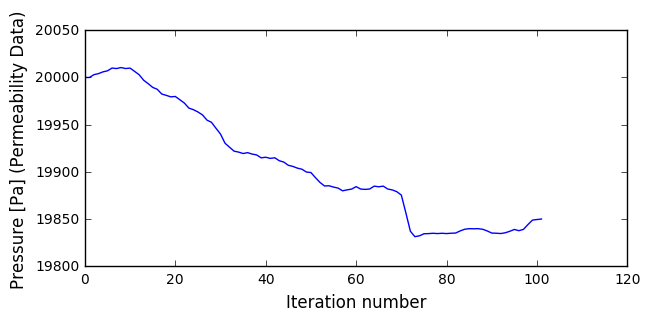

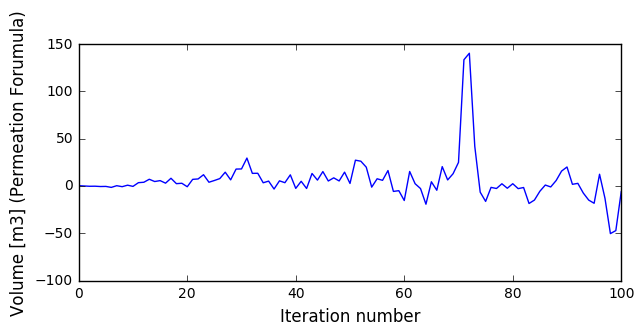

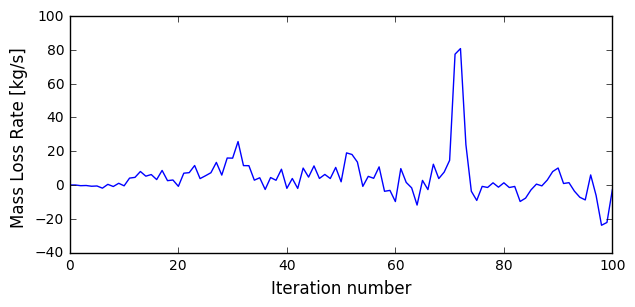

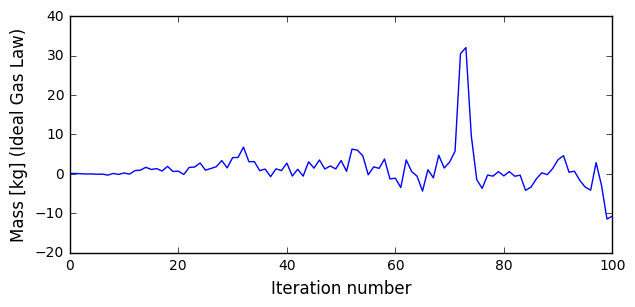

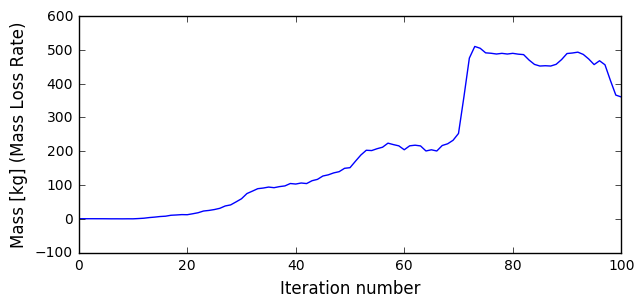

In [22]:
CreateGraphs(range(len(P_perm)),P_perm,"Pressure [Pa] (Permeability Data)","Iteration number",1)
CreateGraphs(range(len(V_new)),V_new,"Volume [m3] (Permeation Forumula)","Iteration number",2)
CreateGraphs(range(len(m_dot)),m_dot,"Mass Loss Rate [kg/s] ","Iteration number",3)
CreateGraphs(range(len(m_ideal)),m_ideal,"Mass [kg] (Ideal Gas Law)","Iteration number",4)
CreateGraphs(range(len(m_perm)),m_perm,"Mass [kg] (Mass Loss Rate)","Iteration number",5)



In [23]:
def getNumber(specific_list,position):
    specific_list=specific_list.tolist()
    if position%2==0: #even numbers
        IndexPosition = specific_list.index(min(specific_list)) #void size is lowest
    else: #uneven number
        IndexPosition = specific_list.index(max(specific_list)) #void size is highest
    return specific_list[IndexPosition]

In [24]:
def getIndex(specific_list,position):
    specific_list=specific_list.tolist()
    if position%2==0:
        IndexPosition = specific_list.index(min(specific_list))
    else:
        IndexPosition = specific_list.index(max(specific_list))
    return IndexPosition 